In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import seaborn as sns

import glob

In [2]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=300, frameon=True, vector_friendly=True, fontsize=10, figsize=(8, 8),
                     color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')

sc.settings.figdir = "scRNA-seq/Redone22/Manuscript/Myeloid"

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

In [3]:
adata = sc.read("scRNA-seq/Redone22/Manuscript/CD45/Data/annotated_CD45.h5ad")
adata.uns['log1p']["base"] = None
adata = adata[adata.obs["leiden_r1.0"].isin(["c8_Myeloid - HLA-DRA", 
                                                 "c11_Myeloid - FTL", 
                                                 "c16_DC1 - CLEC9A", 
                                                 "c18_pDC"])].copy()
print(adata.obs["leiden_r1.0"].unique())

['c8_Myeloid - HLA-DRA', 'c11_Myeloid - FTL', 'c16_DC1 - CLEC9A', 'c18_pDC']
Categories (4, object): ['c8_Myeloid - HLA-DRA', 'c11_Myeloid - FTL', 'c16_DC1 - CLEC9A', 'c18_pDC']


In [4]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20,random_state=0)

In [5]:
res_lst = [0.3, 0.4, 0.5]

for resolution in res_lst:
    sc.tl.leiden(adata, resolution=resolution, key_added=f"leiden_r{resolution}", random_state=0)

In [6]:
sc.tl.umap(adata, random_state=0)

/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


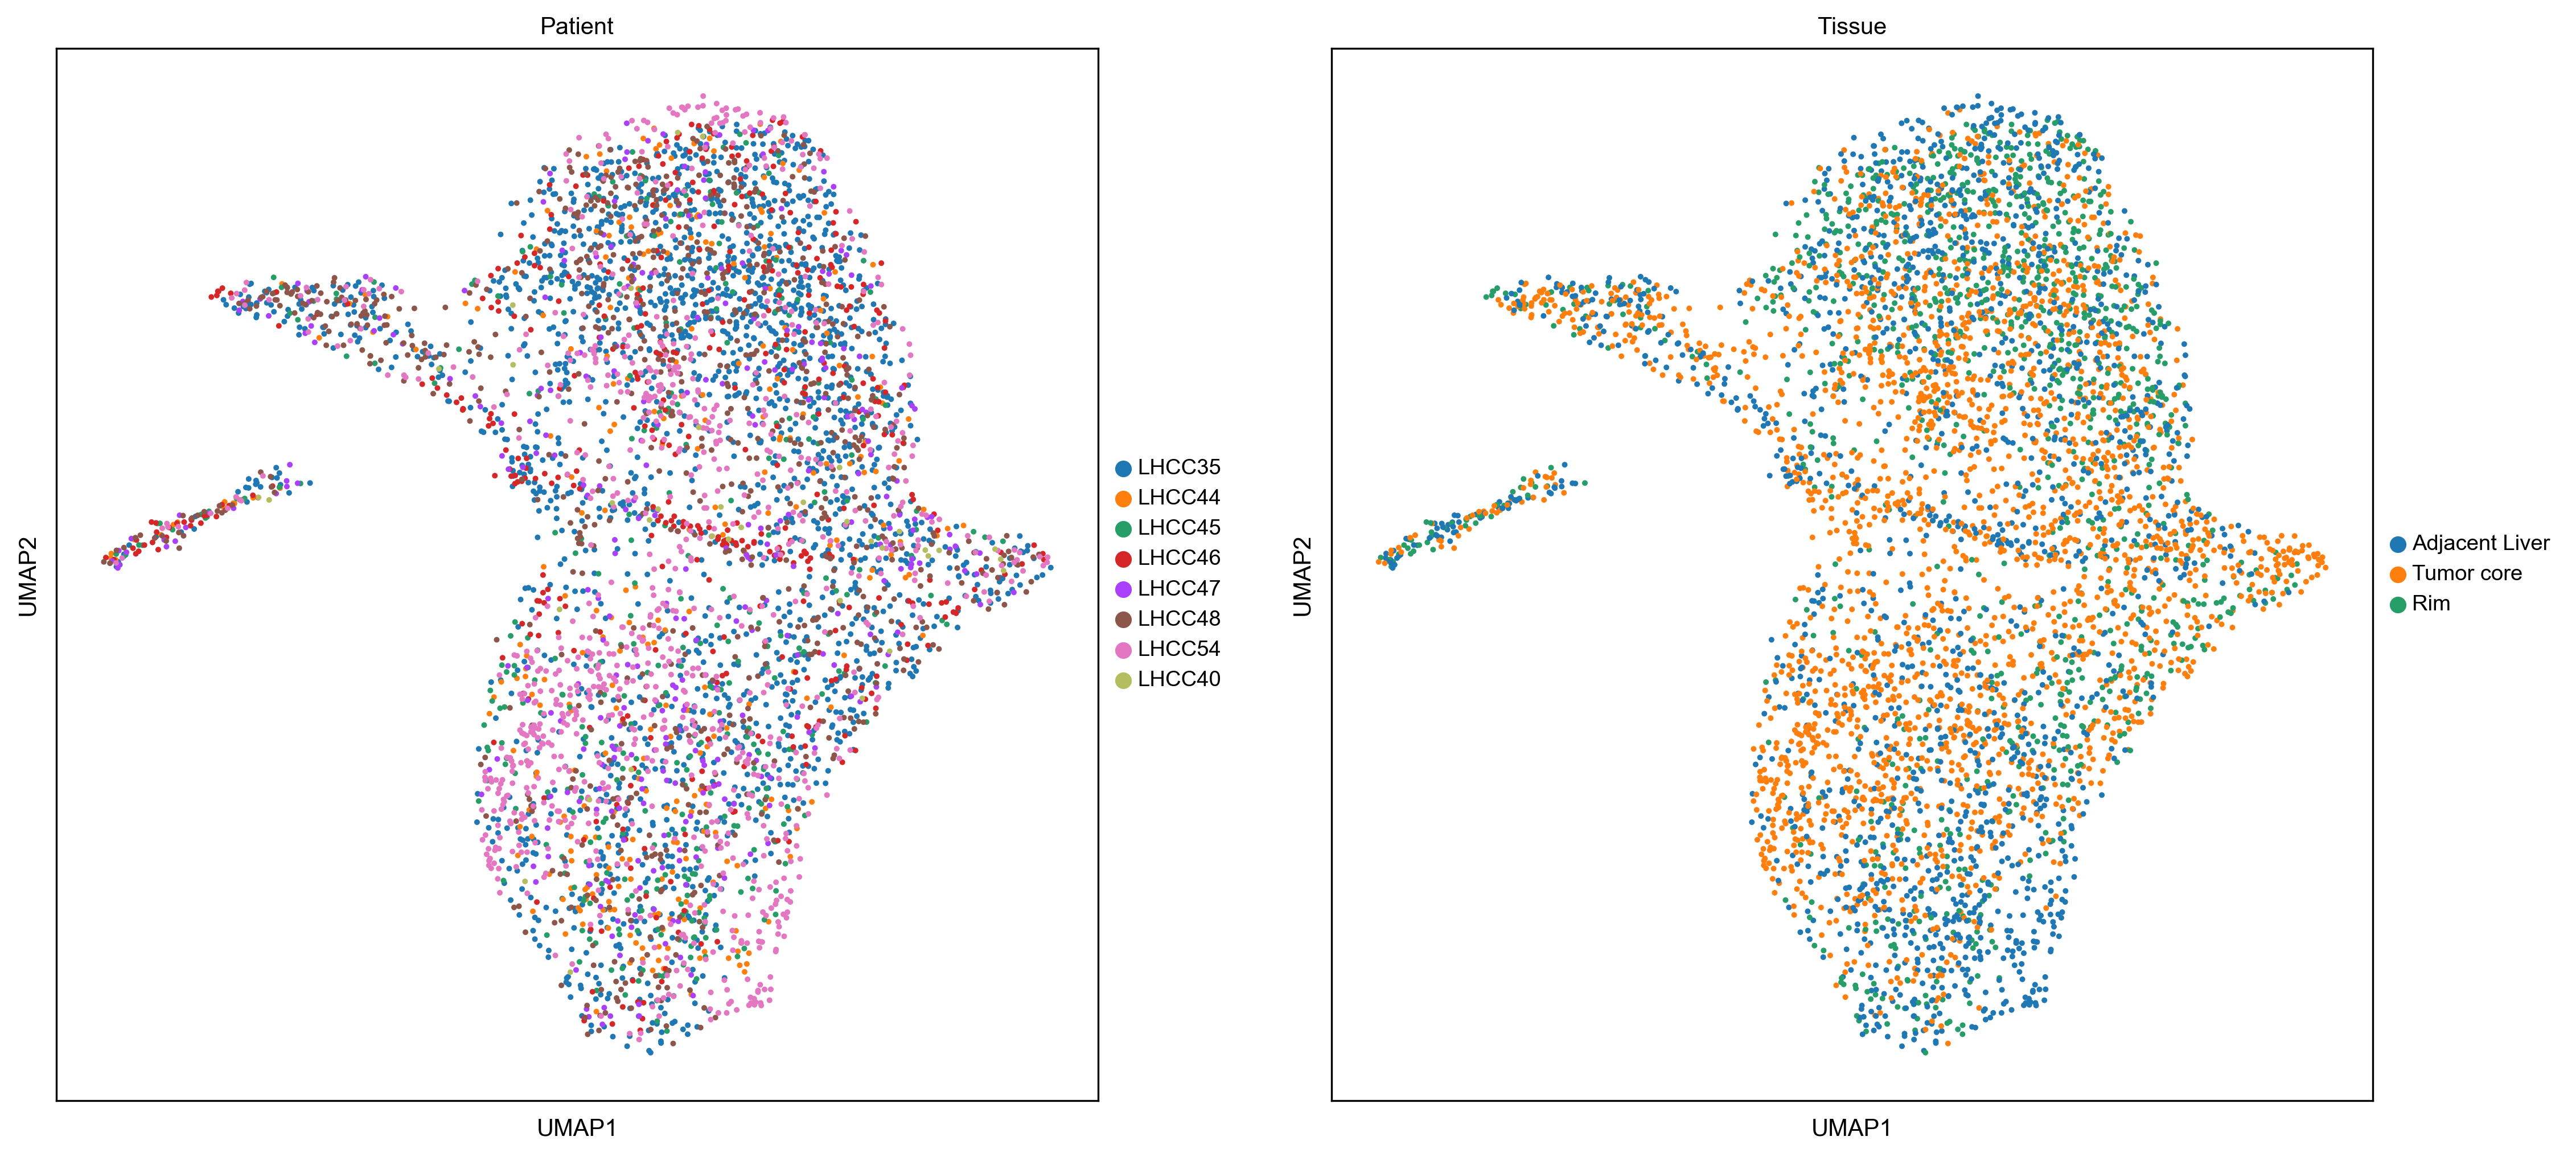

In [7]:
sc.pl.umap(adata, color=["Patient", "Tissue"], save="_Patient_Tissue.pdf")

/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


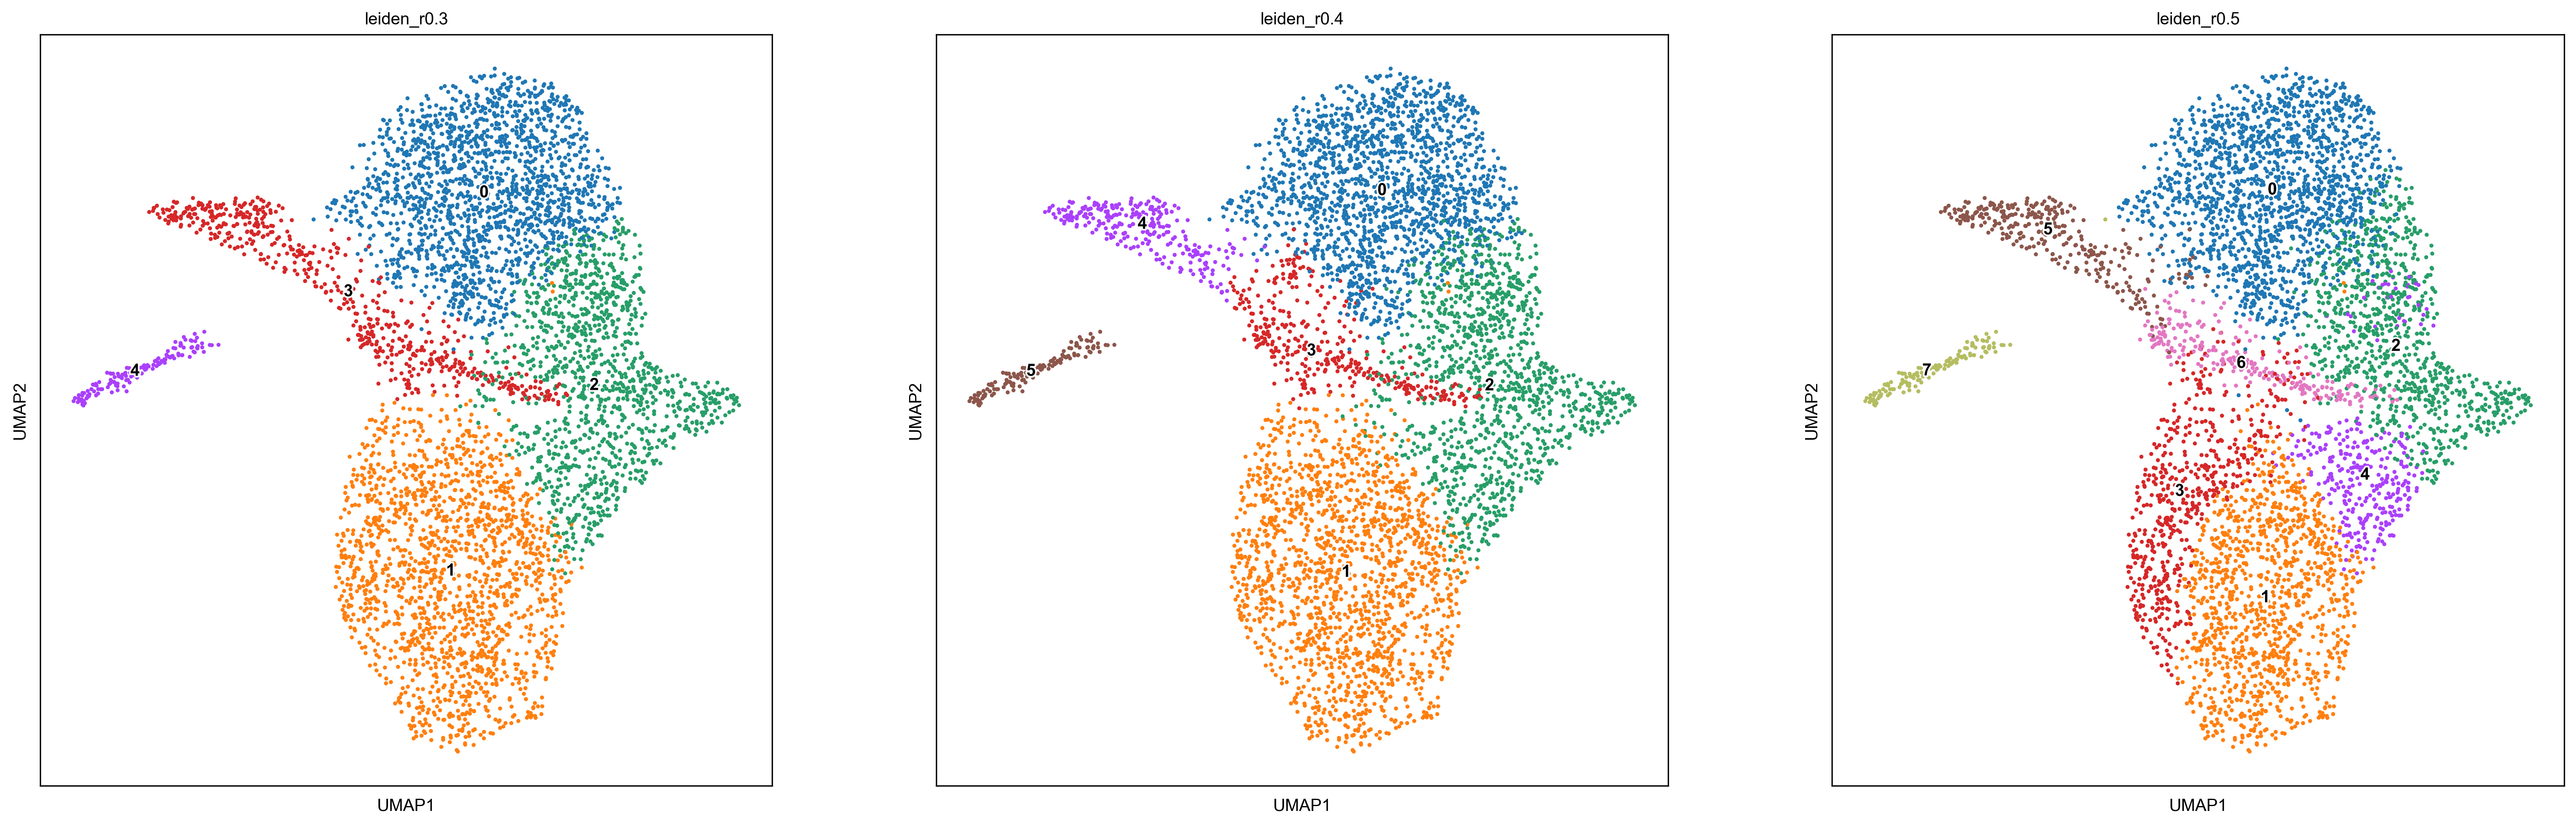

In [8]:
sc.pl.umap(adata, color=[f"leiden_r{r}" for r in res_lst], legend_loc="on data", legend_fontoutline=2, save="_Clusters.pdf")

/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


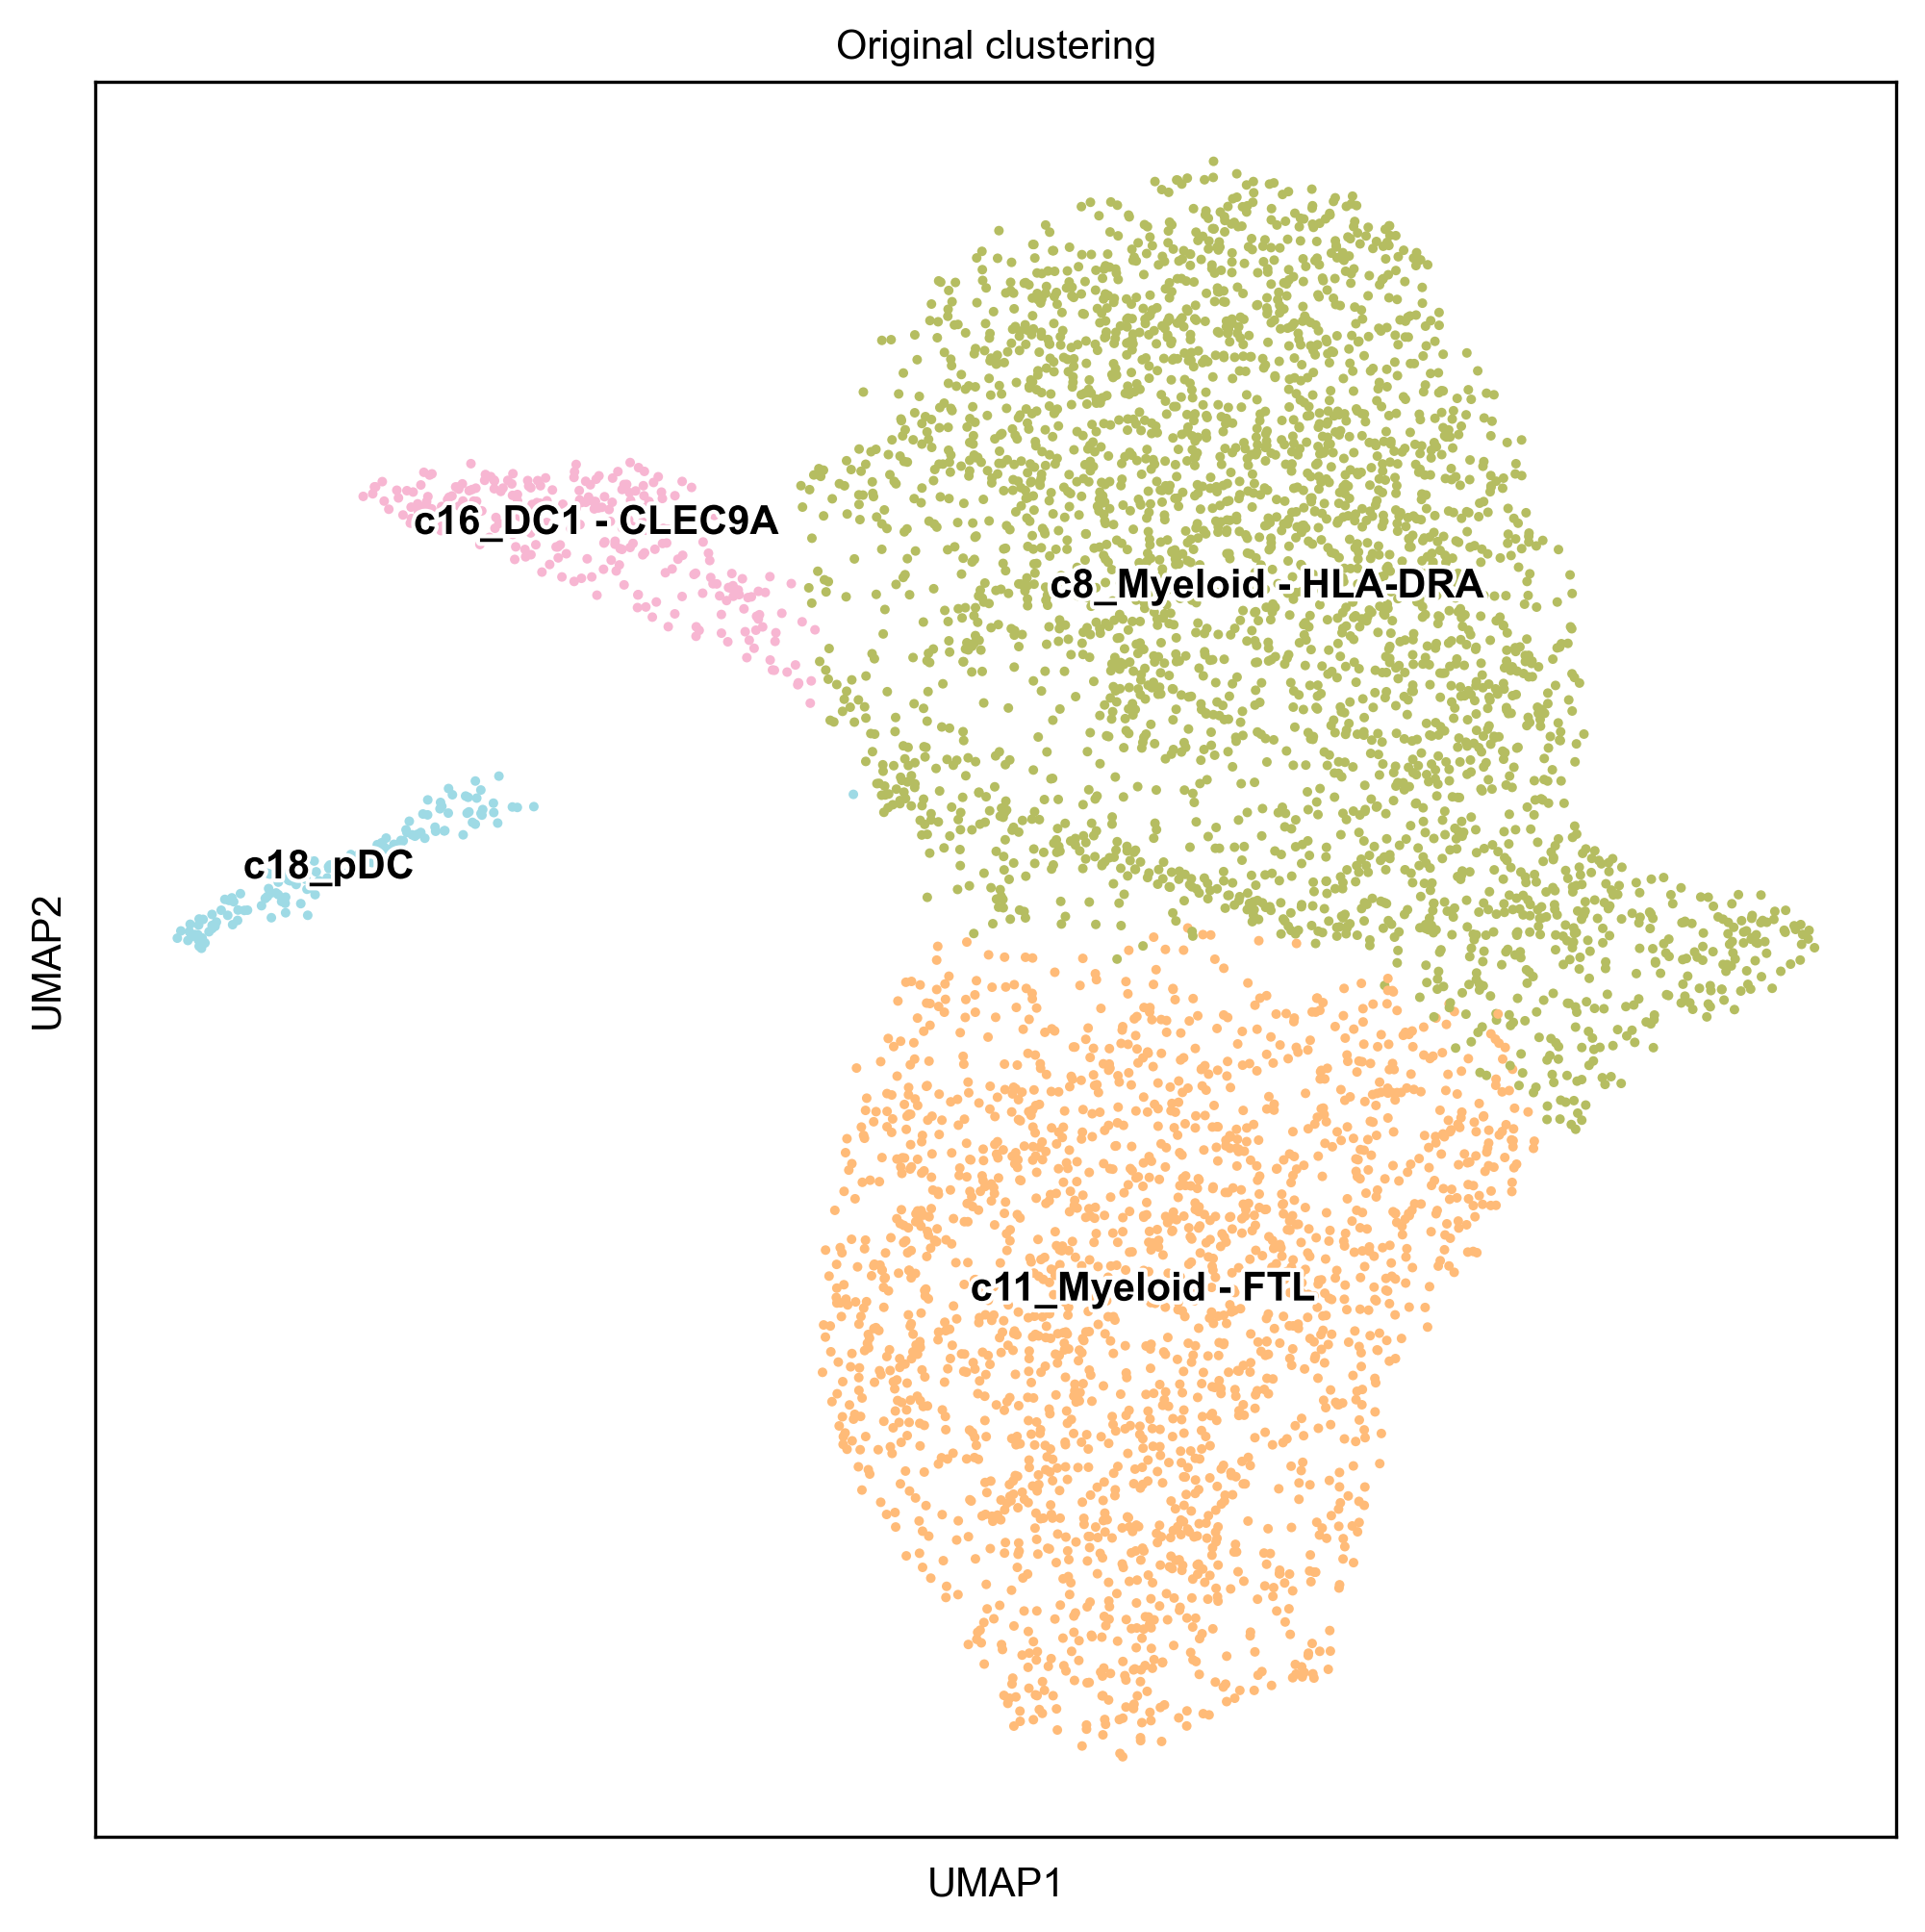

In [9]:
sc.pl.umap(adata, color="leiden_r1.0", title="Original clustering", legend_loc="on data", legend_fontoutline=2, save="_original_Clusters.pdf")

In [10]:
for resolution in res_lst:
    sc.tl.rank_genes_groups(adata, f"leiden_r{resolution}",
                            method="wilcoxon",
                            key_added=f"wilcoxon_r{resolution}",
                            use_raw=True)
    
    
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        sc.tl.rank_genes_groups(adata, f"leiden_r{resolution}", method='wilcoxon', use_raw=True, key_added=f"leiden_r{resolution}_wilcoxon")

        dedf_leiden = sc.get.rank_genes_groups_df(adata,group=None, key=f"leiden_r{resolution}_wilcoxon")
        dedf_leiden.drop("pvals", axis=1, inplace=True)
        dedf_leiden = dedf_leiden[dedf_leiden["pvals_adj"] < 0.05]

    with pd.ExcelWriter(f"scRNA-seq/Redone22/Manuscript/Myeloid/DGE/leiden_r{resolution}.xlsx") as writer:
        for cluster_id in dedf_leiden.group.unique():
            df_sub_cl = dedf_leiden[dedf_leiden.group == cluster_id].copy()
            df_sub_cl.to_excel(writer, sheet_name=f"c{cluster_id}")

    del df_sub_cl
    del dedf_leiden

In [14]:
cluster_mapper = {"0":  "c1-DC-CD1C",
                  "1":  "c2-Mφ-S100A9",
                  "2":  "c3-Mφ-C1QA",
                  "3":  "c4-Mono-ZFP36",
                  "4":  "c5-DC-CLEC9A",
                  "5":  "c6-pDC"}

adata.obs["leiden_r0.4"].replace(cluster_mapper, inplace=True)

In [22]:
adata.write("scRNA-seq/Redone22/Manuscript/Myeloid/Data/processed_20022023.h5ad")

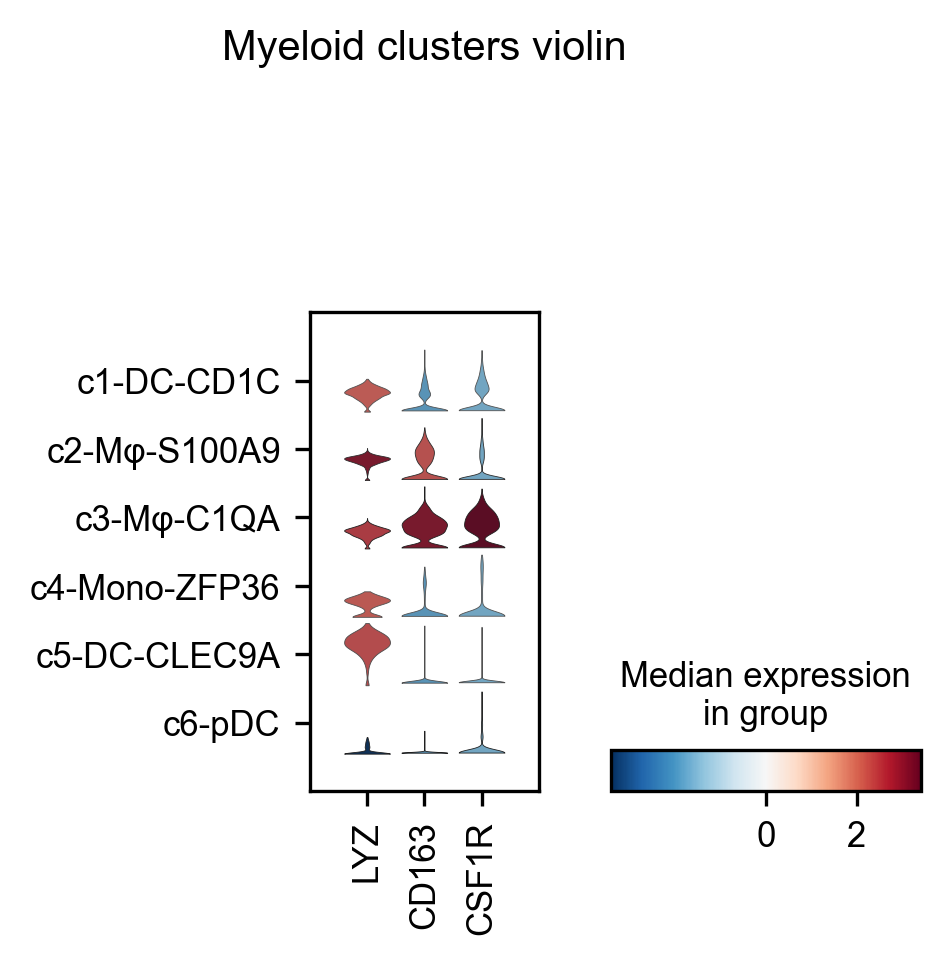

In [16]:
resolution = 0.4
sc.pl.stacked_violin(adata, ["LYZ", "CD163", "CSF1R"], groupby=f"leiden_r{resolution}", dendrogram=False, use_raw=False, 
                     swap_axes=False, vcenter=0, cmap="RdBu_r", save="_Myeloid.pdf", title="Myeloid clusters violin")

In [17]:
myeloid_genes = ["LYZ", "CD14", "ITGAX", "ITGAM", "CD68", "CSF1R", "CD163", "HLA-DQA1", "FCER1A", "CD1C", "CLEC10A", "S100A9", "TSPO", "FCN1", "TYROBP", "C1QA", 
                 "MRC1", "MARCO", "VSIG4", "ZFP36", "IL32", "SELENOP", "CCL5", "CLEC9A", "IDO1", "CD74", "C1orf54", "GZMB", "LILRA4", "IL3RA", "CXCR3"]

In [18]:
res = pd.DataFrame(columns=adata.var_names, index=adata.obs["leiden_r0.4"].cat.categories)                                                                                                 

for clust in adata.obs["leiden_r0.4"].cat.categories: 
    res.loc[clust] = adata[adata.obs["leiden_r0.4"].isin([clust]),:].X.mean(0)

In [19]:
res = res[myeloid_genes].copy()

In [20]:
for col in res.columns:
    res[col] = res[col].astype(np.float32)
    res[col] = (res[col]-res[col].mean())/res[col].std()

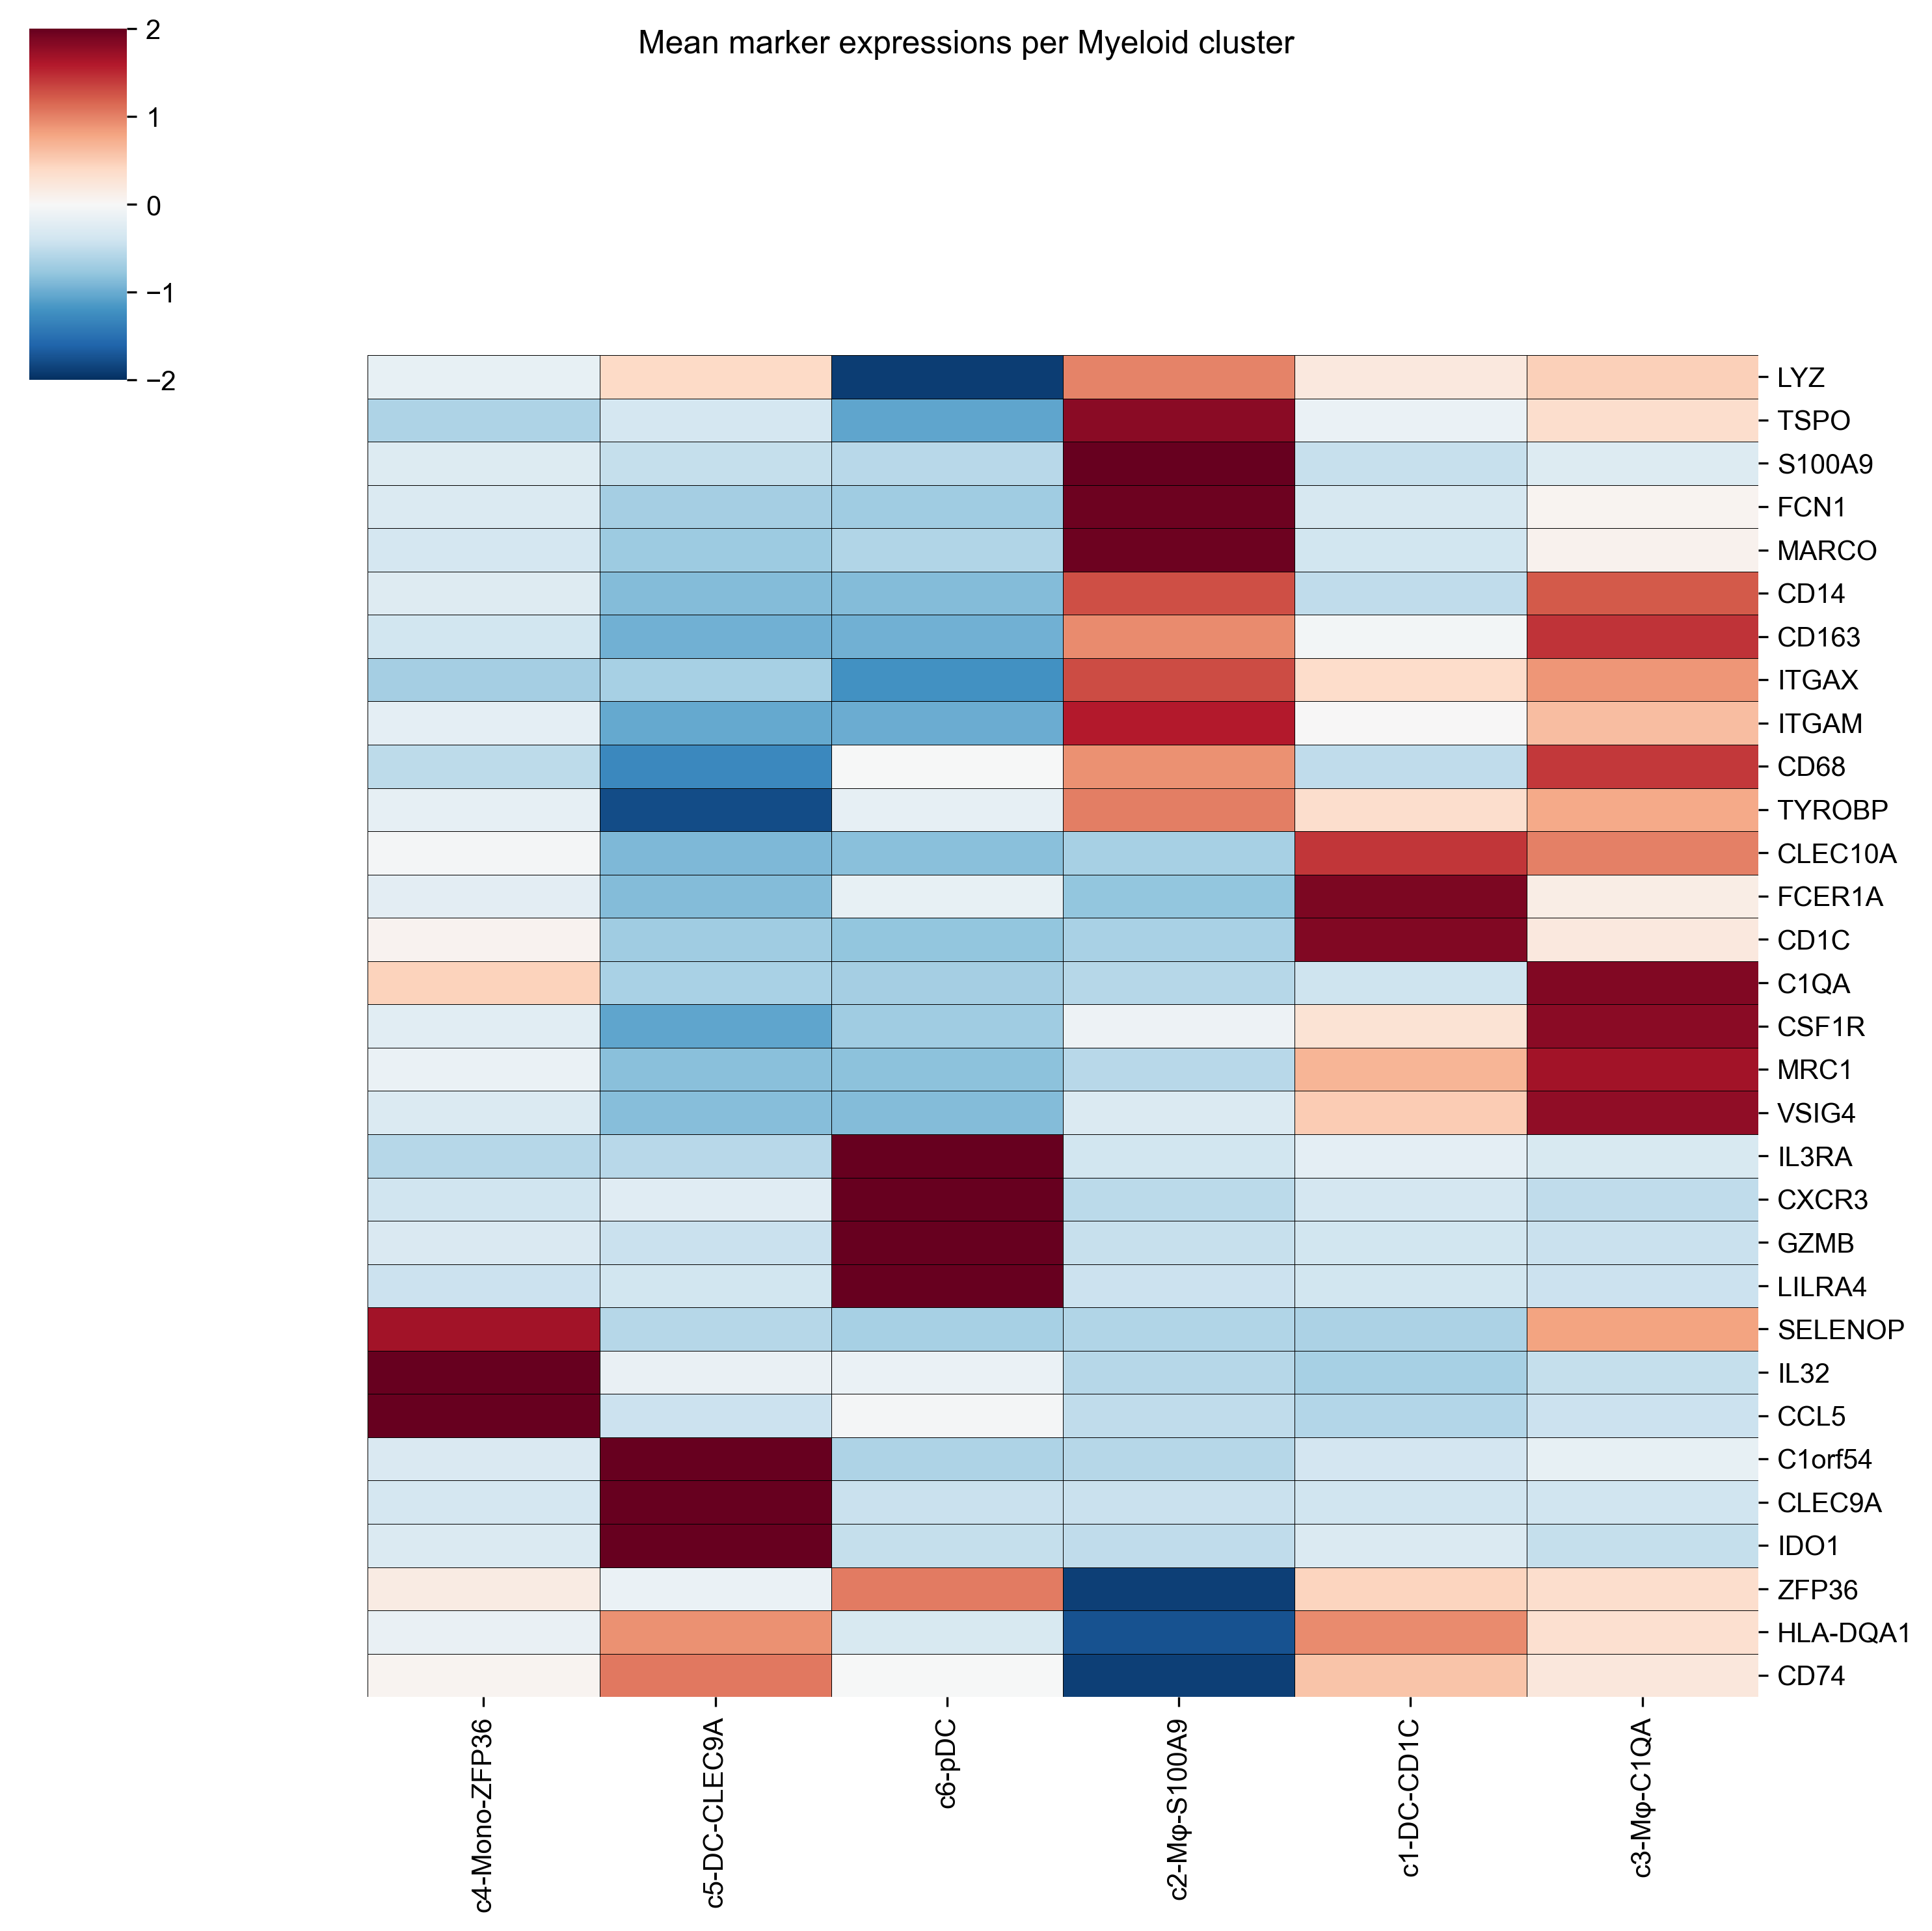

In [21]:
g = sns.clustermap(data=res.T, cmap="RdBu_r", center=0, vmin=-2, vmax=2, yticklabels=1, linewidths=0.2, metric="correlation",
                   linecolor="black",tree_kws={"linewidths": 0.})
plt.suptitle("Mean marker expressions per Myeloid cluster")
plt.savefig("scRNA-seq/Redone22/Manuscript/Myeloid/Myeloid_Heatmap.pdf", dpi=400, transparent=True)
plt.show()